In [2]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer

# Load dataset
df = pd.read_csv('f1_2019_to_2023_all_drivers_all_data.csv', low_memory=False)

# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original Driver and Circuit for EDA
df['Original_Driver'] = df['Driver']
df['Original_Circuit'] = df['Circuit']

# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013,55], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High','v'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus','Circuit'])

# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time']
df.drop(columns=columns_to_drop, inplace=True)


# Select numerical values for scaling and imputation
numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']


df[numeric_features] = df[numeric_features].fillna(method='ffill')


## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method that effective to removes extreme outliers
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry
df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]
df_dry_filtered = df_dry_filtered.copy()
df_wet = df_wet.copy()

#SHould I have to do this for also wet days and other features??


# Combining the datasets after scaling
df_combined = pd.concat([df_dry_filtered, df_wet], ignore_index=True)
df_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96556 entries, 0 to 96555
Data columns (total 148 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    SpeedI1                              float64 
 5    SpeedI2                              float64 
 6    SpeedFL                              float64 
 7    SpeedST                              float64 
 8    TyreLife                             float64 
 9    FreshTyre                            int64   
 10   Position                             float64 
 11   IsAccurate                           int64   
 12   AirTemp                              float64 
 13   Humidity                             float64 
 14   Pressure                             float64 
 15   

/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_36703/66651581.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_features] = df[numeric_features].fillna(method='ffill')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


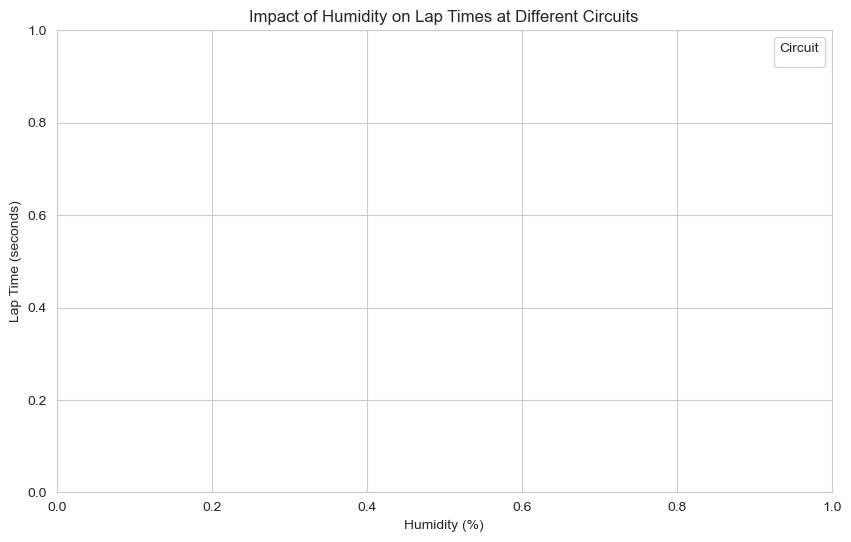

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


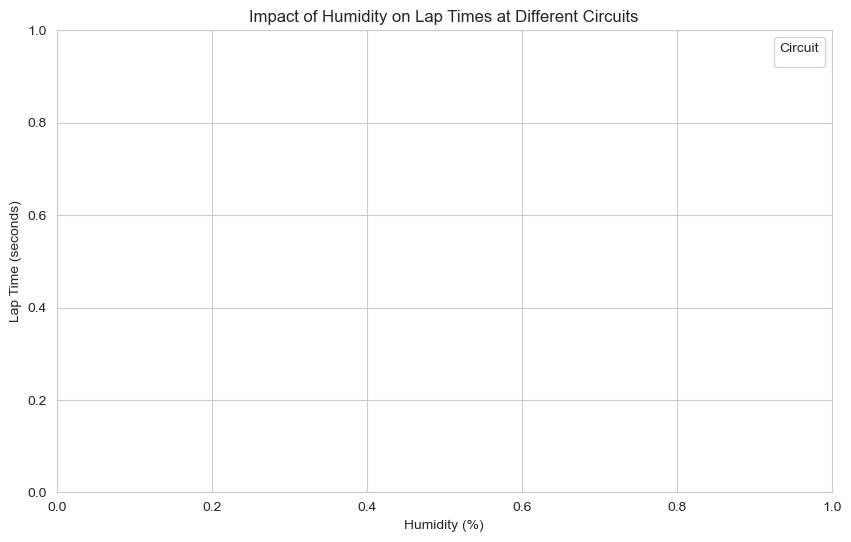

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtering data for the specific circuits of interest
circuits_of_interest = ['Malaysian Grand Prix']
df_filtered = df_dry_filtered[df_dry_filtered['Original_Circuit'].isin(circuits_of_interest)]

# Plotting humidity vs. lap time for each circuit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Humidity', y='LapTime', hue='Original_Circuit')
plt.title('Impact of Humidity on Lap Times at Different Circuits')
plt.xlabel('Humidity (%)')
plt.ylabel('Lap Time (seconds)')
plt.legend(title='Circuit')
plt.grid(True)
plt.show()

# To see more granular details, consider using a line plot with a smoother curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x='Humidity', y='LapTime', hue='Original_Circuit', marker='o')
plt.title('Impact of Humidity on Lap Times at Different Circuits')
plt.xlabel('Humidity (%)')
plt.ylabel('Lap Time (seconds)')
plt.legend(title='Circuit')
plt.grid(True)
plt.show()


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


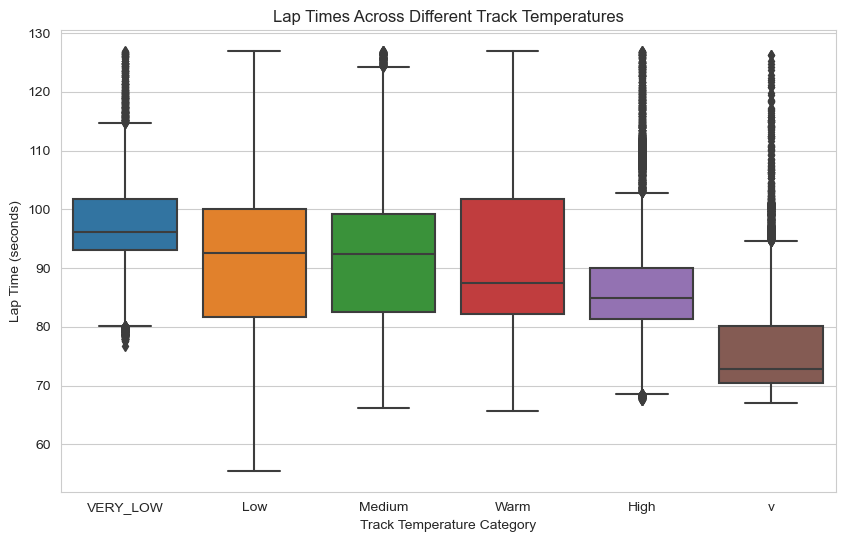

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.boxplot(x='Original_TrackTemp_Cat', y='LapTime', data=df_dry_filtered)
plt.title('Lap Times Across Different Track Temperatures')
plt.xlabel('Track Temperature Category')
plt.ylabel('Lap Time (seconds)')
plt.show()

count    100588.000000
mean         34.970074
std           9.184423
min          13.800000
25%          28.400000
50%          34.300000
75%          41.700000
max          57.500000
Name: TrackTemp, dtype: float64


ValueError: bins must increase monotonically.

In [3]:



correlation_matrix= df_combined[numeric_features + ['LapTime']+['Rainfall'] ].corr()

# Focus on 'LapTime' correlations
laptime_correlations = correlation_matrix['LapTime'].drop('LapTime')  # drop self-correlation

# Convert correlations to percentage and sort in descending order
laptime_correlations_percentage = laptime_correlations * 100
laptime_correlations_sorted = laptime_correlations_percentage.sort_values(ascending=False)

# Convert to list and format the output
laptime_correlations_list = [(f"{index}: {value:.2f}%") for index, value in laptime_correlations_sorted.items()]

# Print the formatted list
for item in laptime_correlations_list:
    print(item)

# Optionally, visualize the correlations in descending order
plt.figure(figsize=(10, 8))
laptime_correlations_sorted.plot(kind='bar')
plt.title('Percentage Correlation of LapTime with Other Variables')
plt.ylabel('Correlation Percentage')
plt.xlabel('Variables')
plt.grid(True)
plt.show()


Humidity: 22.99%
Pressure: 19.27%
WindDirection: 14.46%
Rainfall: 7.87%
WindSpeed: 6.72%
AirTemp: -2.23%
SpeedI2: -11.66%
TrackTemp: -23.17%
SpeedST: -24.55%
SpeedI1: -30.55%
SpeedFL: -37.43%


NameError: name 'plt' is not defined

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

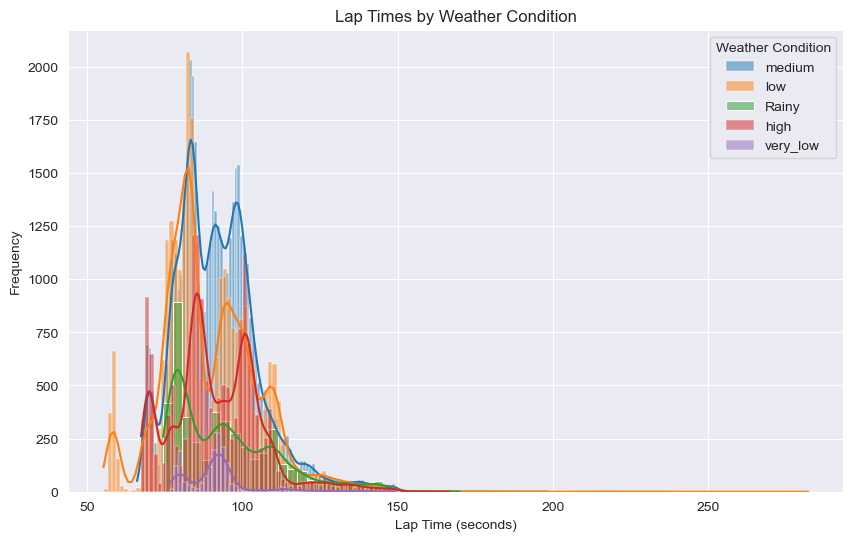

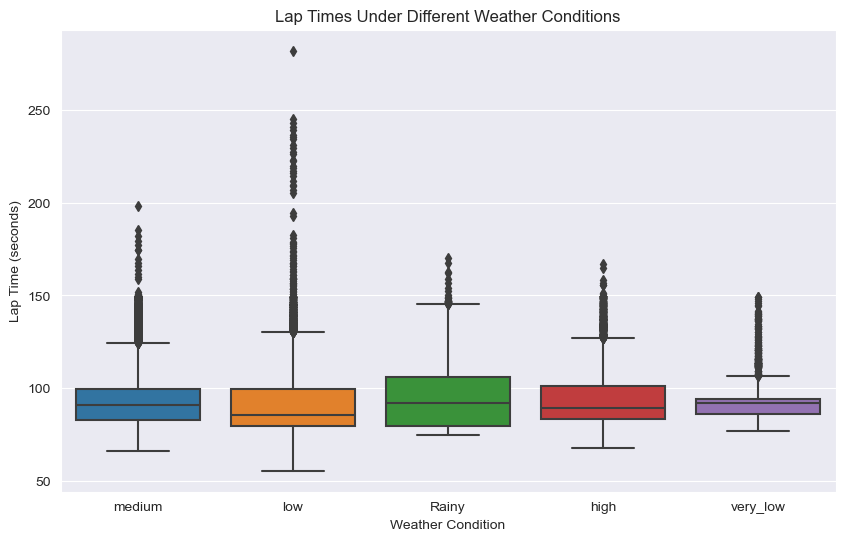

In [4]:
#EDA - Visualization

plt.figure(figsize=(10, 6))

# Unique categories in the 'Original_Weather_Category' column
weather_categories = df['Original_Weather_Category'].unique()
# Plot histogram for each weather category
for category in weather_categories:
    # Select lap times for the current category
    category_lap_times = df[df['Original_Weather_Category'] == category]['LapTime']
    # Plot the distribution of lap times for the category
    sns.histplot(category_lap_times, kde=True, label=category)

# Plotting
plt.title('Lap Times by Weather Condition')
plt.xlabel('Lap Time (seconds)')
plt.ylabel('Frequency')
plt.legend(title='Weather Condition')
plt.show()


# Second graph with box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Original_Weather_Category', y='LapTime', data=df)
plt.title('Lap Times Under Different Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Lap Time (seconds)')
plt.show()

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

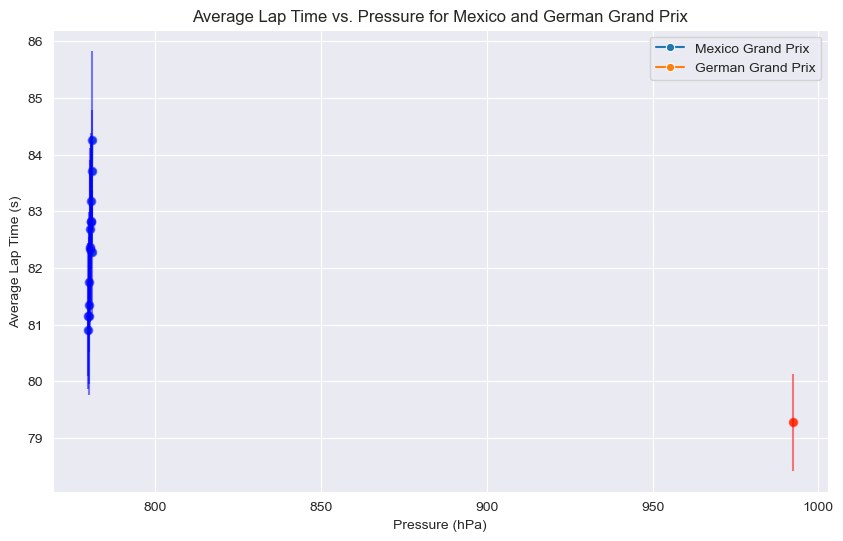

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def remove_outliers(df):
    Q1 = df['LapTime'].quantile(0.25)
    Q3 = df['LapTime'].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df['LapTime'] >= Q1 - 1.5 * IQR) & (df['LapTime'] <= Q3 + 1.5 * IQR)]

# Filter data for Mexican Grand Prix and Dutch Grand Prix
mexico_data = df_dry_filtered[df_dry_filtered['Circuit_Mexican Grand Prix'] == 1]
dutch_data = df_dry_filtered[df_dry_filtered['Circuit_German Grand Prix'] == 1]

# Remove outliers
mexico_data_clean = remove_outliers(mexico_data)
dutch_data_clean = remove_outliers(dutch_data)

# Group by Pressure and calculate mean LapTime
mexico_avg = mexico_data_clean.groupby('Pressure')['LapTime'].mean().reset_index()
dutch_avg = dutch_data_clean.groupby('Pressure')['LapTime'].mean().reset_index()

# Calculate the standard deviation for error bars
mexico_std = mexico_data_clean.groupby('Pressure')['LapTime'].std().reset_index()
dutch_std = dutch_data_clean.groupby('Pressure')['LapTime'].std().reset_index()

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plotting line plot for Mexico Grand Prix with error bars
sns.lineplot(x='Pressure', y='LapTime', data=mexico_avg, marker='o', label='Mexico Grand Prix')
plt.errorbar(mexico_avg['Pressure'], mexico_avg['LapTime'], yerr=mexico_std['LapTime'], fmt='o', color='blue', alpha=0.5)

# Plotting line plot for Dutch Grand Prix with error bars
sns.lineplot(x='Pressure', y='LapTime', data=dutch_avg, marker='o', label='German Grand Prix')
plt.errorbar(dutch_avg['Pressure'], dutch_avg['LapTime'], yerr=dutch_std['LapTime'], fmt='o', color='red', alpha=0.5)

plt.title('Average Lap Time vs. Pressure for Mexico and German Grand Prix')
plt.xlabel('Pressure (hPa)')
plt.ylabel('Average Lap Time (s)')
plt.legend()
plt.grid(True)
plt.show()



Mexico Mean Lap Time: 82.15 seconds
Mexico Mean Pressure: 780.25 hPa
German Mean Lap Time: 79.28 seconds
German Mean Pressure: 992.20 hPa


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


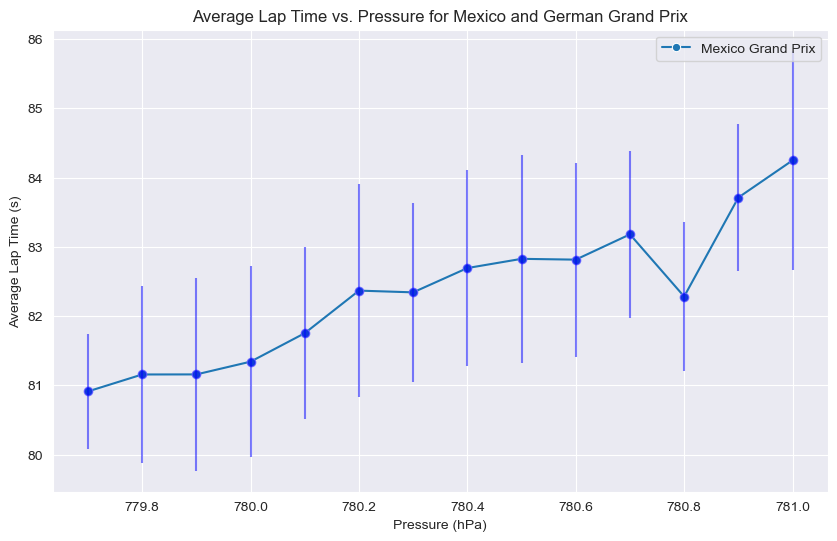

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Assuming df_dry_filtered is already defined and contains columns named correctly for circuits
# Filter data for Mexican Grand Prix and German Grand Prix
mexico_data = df_dry_filtered[df_dry_filtered['Original_Circuit'] == 'Mexican Grand Prix']
german_data = df_dry_filtered[df_dry_filtered['Original_Circuit'] == 'German Grand Prix']




# Remove outliers
mexico_data_clean = remove_outliers(mexico_data)
german_data_clean = remove_outliers(german_data)

# Calculate mean LapTime and mean Pressure
mexico_mean_laptime = mexico_data_clean['LapTime'].mean()
mexico_mean_pressure = mexico_data_clean['Pressure'].mean()
german_mean_laptime = german_data_clean['LapTime'].mean()
german_mean_pressure = german_data_clean['Pressure'].mean()

print(f"Mexico Mean Lap Time: {mexico_mean_laptime:.2f} seconds")
print(f"Mexico Mean Pressure: {mexico_mean_pressure:.2f} hPa")
print(f"German Mean Lap Time: {german_mean_laptime:.2f} seconds")
print(f"German Mean Pressure: {german_mean_pressure:.2f} hPa")

# Group by Pressure and calculate mean LapTime for plotting
mexico_avg = mexico_data_clean.groupby('Pressure')['LapTime'].mean().reset_index()
german_avg = german_data_clean.groupby('Pressure')['LapTime'].mean().reset_index()

# Calculate the standard deviation for error bars
mexico_std = mexico_data_clean.groupby('Pressure')['LapTime'].std().reset_index()
german_std = german_data_clean.groupby('Pressure')['LapTime'].std().reset_index()

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plotting line plot for Mexico Grand Prix with error bars
sns.lineplot(x='Pressure', y='LapTime', data=mexico_avg, marker='o', label='Mexico Grand Prix')
plt.errorbar(mexico_avg['Pressure'], mexico_avg['LapTime'], yerr=mexico_std['LapTime'], fmt='o', color='blue', alpha=0.5)



plt.title('Average Lap Time vs. Pressure for Mexico and German Grand Prix')
plt.xlabel('Pressure (hPa)')
plt.ylabel('Average Lap Time (s)')
plt.legend()
plt.grid(True)
plt.show()


Mexico Mean Lap Time: 82.15 seconds
Mexico Mean Pressure: 780.25 hPa
German Mean Lap Time: nan seconds
German Mean Pressure: nan hPa


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


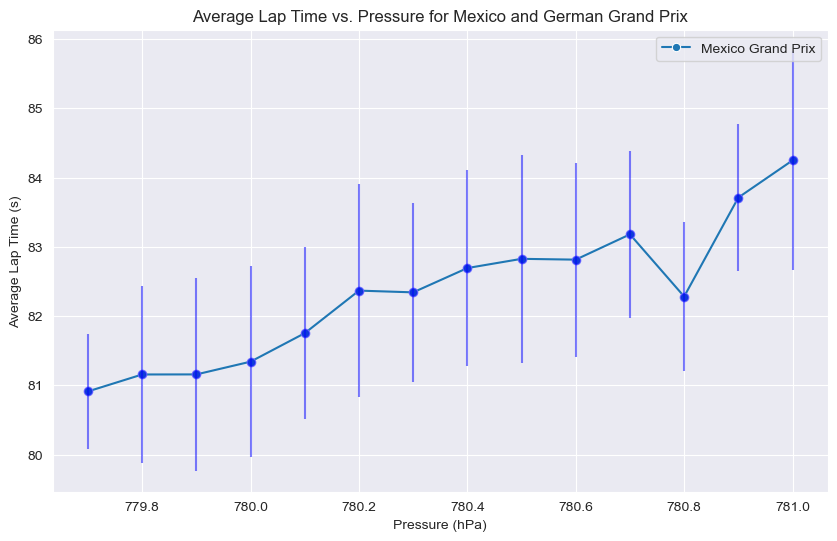

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Assuming df_dry_filtered is already defined and contains columns named correctly for circuits
# Filter data for Mexican Grand Prix and German Grand Prix
mexico_data = df_dry_filtered[df_dry_filtered['Original_Circuit'] == 'Mexican Grand Prix']
german_data = df_dry_filtered[df_dry_filtered['Original_Circuit'] == 'Spain Grand Prix']





# Remove outliers
mexico_data_clean = remove_outliers(mexico_data)
german_data_clean = remove_outliers(german_data)

# Calculate mean LapTime and mean Pressure
mexico_mean_laptime = mexico_data_clean['LapTime'].mean()
mexico_mean_pressure = mexico_data_clean['Pressure'].mean()
german_mean_laptime = german_data_clean['LapTime'].mean()
german_mean_pressure = german_data_clean['Pressure'].mean()

print(f"Mexico Mean Lap Time: {mexico_mean_laptime:.2f} seconds")
print(f"Mexico Mean Pressure: {mexico_mean_pressure:.2f} hPa")
print(f"German Mean Lap Time: {german_mean_laptime:.2f} seconds")
print(f"German Mean Pressure: {german_mean_pressure:.2f} hPa")

# Group by Pressure and calculate mean LapTime for plotting
mexico_avg = mexico_data_clean.groupby('Pressure')['LapTime'].mean().reset_index()
german_avg = german_data_clean.groupby('Pressure')['LapTime'].mean().reset_index()

# Calculate the standard deviation for error bars
mexico_std = mexico_data_clean.groupby('Pressure')['LapTime'].std().reset_index()
german_std = german_data_clean.groupby('Pressure')['LapTime'].std().reset_index()

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plotting line plot for Mexico Grand Prix with error bars
sns.lineplot(x='Pressure', y='LapTime', data=mexico_avg, marker='o', label='Mexico Grand Prix')
plt.errorbar(mexico_avg['Pressure'], mexico_avg['LapTime'], yerr=mexico_std['LapTime'], fmt='o', color='blue', alpha=0.5)



plt.title('Average Lap Time vs. Pressure for Mexico and German Grand Prix')
plt.xlabel('Pressure (hPa)')
plt.ylabel('Average Lap Time (s)')
plt.legend()
plt.grid(True)
plt.show()
